In [23]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta
from scipy.stats import trim_mean
import bottleneck as bn

In [24]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [25]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [26]:
def calculate_volume_anomaly_factor(df):
    """
    优化后的基于成交量异常的因子计算
    主要优化点：
    1. 使用向量化操作替代循环
    2. 预计算所有可能需要的收益率序列
    3. 使用bottleneck进行高效数值计算
    4. 优化异常点检测逻辑
    """
    # 参数设置
    N_periods = 100  # 历史窗口大小
    N_returns = 10   # 收益率序列长度
    
    # 预计算所有收益率 (开盘价到收盘价的收益率)
    returns = (df['close'] - df['open']) / df['open']
    
    # 创建全量收益率DataFrame用于快速查询
    future_rets = pd.DataFrame(index=df.index)
    for i in range(1, N_returns+1):
        future_rets[f'ret_{i}'] = returns.shift(-i)
    
    # 初始化因子值序列
    factor_values = pd.Series(np.nan, index=df.index)
    
    # 使用滚动窗口进行向量化计算
    # 创建成交量序列
    volumes = df['volume'].values
    
    # 计算滚动截断均值 (排除5%极端值)
    trim_means = pd.Series(volumes).rolling(N_periods, min_periods=N_periods).apply(
        lambda x: trim_mean(x, 0.05), raw=True
    ).values
    
    # 计算滚动截断标准差
    trim_stds = pd.Series(volumes).rolling(N_periods, min_periods=N_periods).apply(
        lambda x: bn.nanstd(x[(x >= np.quantile(x, 0.05)) & (x <= np.quantile(x, 0.95))]), 
        raw=True
    ).values
    
    # 创建异常点掩码 (volume > μ + 2σ)
    anomaly_mask = (volumes > trim_means + 2 * trim_stds) & \
                  (pd.notna(trim_means)) & \
                  (pd.notna(trim_stds))
    
    # 主处理循环 - 只处理有足够数据的点
    for i in range(N_periods, len(df)):
        # 只处理有异常的点
        if not anomaly_mask[i]:
            continue
            
        # 获取当前窗口内的所有异常点
        start_idx = max(0, i - N_periods)
        window_anomalies = np.where(anomaly_mask[start_idx:i])[0] + start_idx
        
        # 筛选有效的异常点 (有完整的后续收益率数据)
        valid_anomalies = [j for j in window_anomalies if j + N_returns < i]
        
        if not valid_anomalies:
            continue
            
        # 提取所有有效异常点的后续收益率
        all_returns = future_rets.iloc[valid_anomalies].values.flatten()
        all_returns = all_returns[~np.isnan(all_returns)]
        
        if len(all_returns) == 0:
            continue
            
        # 分离正负收益率
        positive_returns = all_returns[all_returns > 0]
        negative_returns = all_returns[all_returns < 0]
        
        # 使用bottleneck加速均值计算
        mean_positive = bn.nanmean(positive_returns) if len(positive_returns) > 0 else 0
        mean_negative = bn.nanmean(negative_returns) if len(negative_returns) > 0 else 0
        
        # 计算因子值
        factor_values.iloc[i] = mean_positive - mean_negative
    
    return factor_values

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.032448
   Rank_IC (Spearman): 0.018680
📊 信息比率:
   IR: 0.018334
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 14004
   因子列: volume_anomaly_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


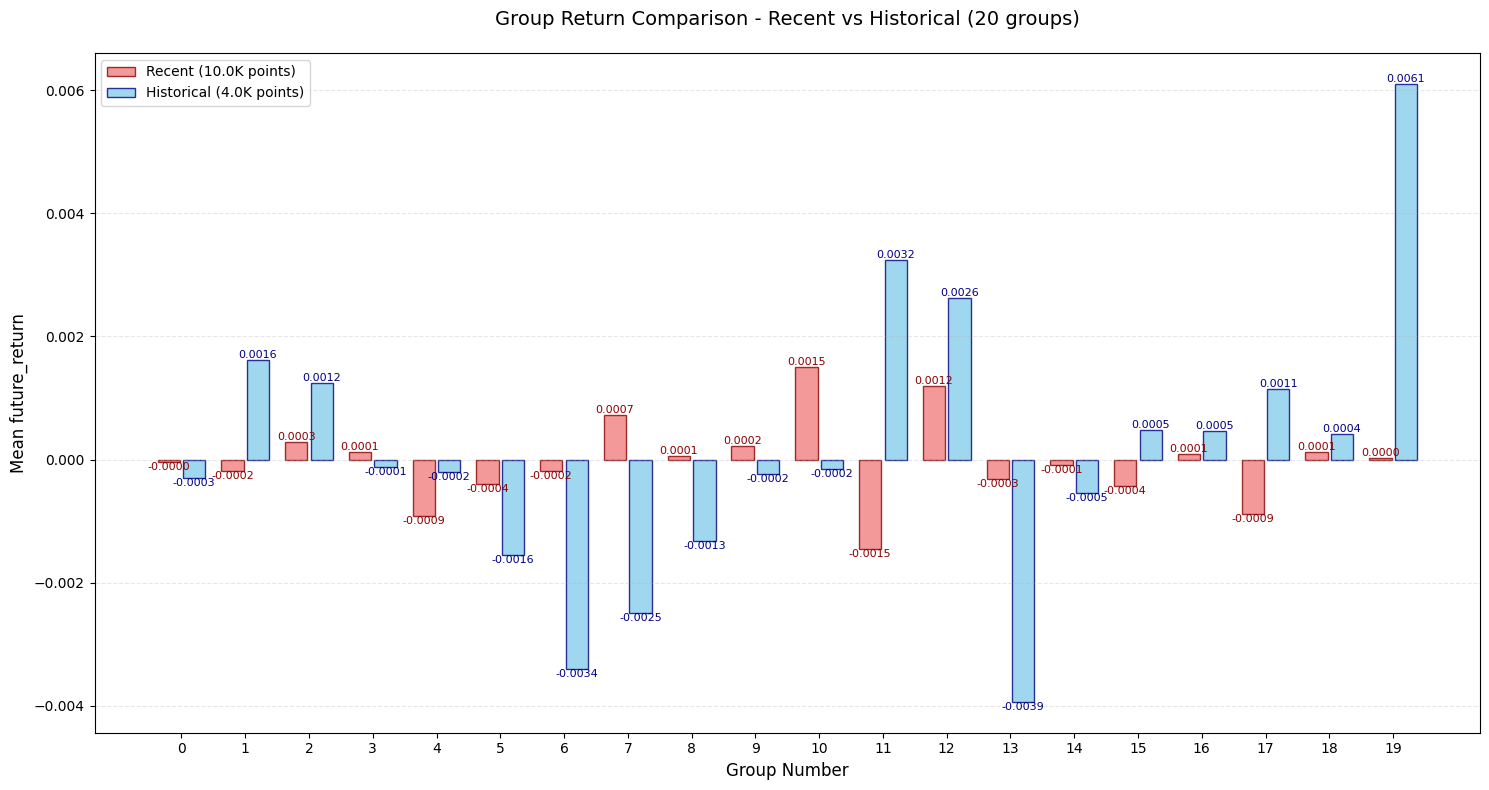

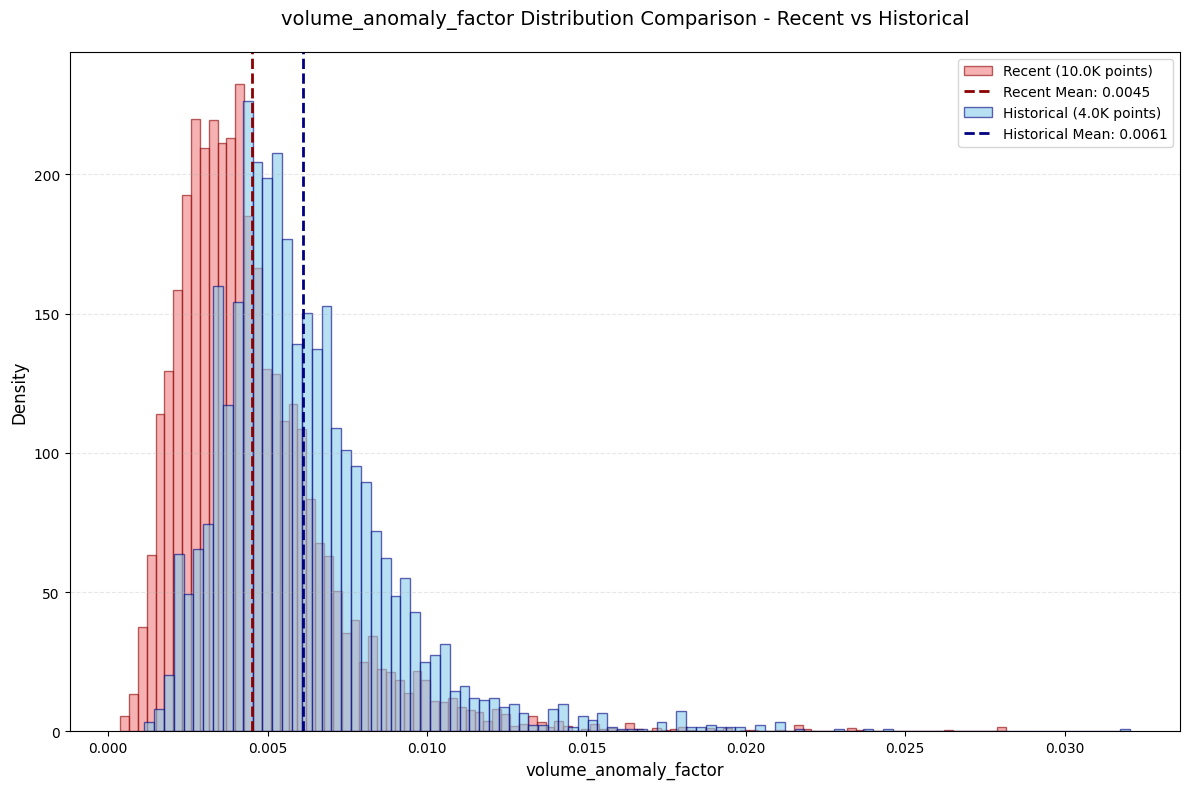

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [27]:
evaluator.set_factor(
    factor_func=calculate_volume_anomaly_factor,
    factor_name='volume_anomaly_factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

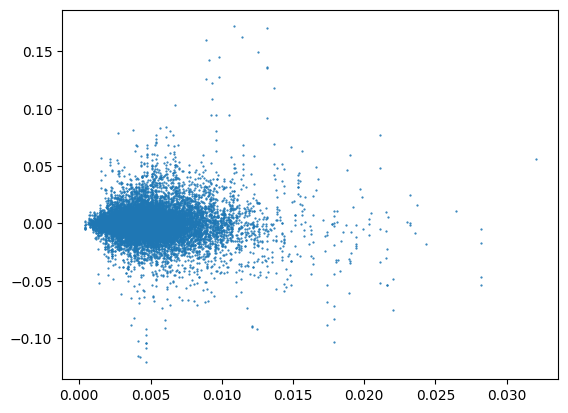

In [28]:
import matplotlib.pyplot as plt
plt.scatter(calculate_volume_anomaly_factor(df),df['close'].pct_change(-10), s=0.3)

In [29]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.040153568739434695,
 -0.06365633234407556,
 0.016774665188138516,
 -0.02112621156382169,
 -0.026844538712830376,
 0.0051892480417679125,
 0.009846955213581548,
 -0.002486008181161555,
 0.040180861745605125,
 0.08981595455430384]

In [30]:
print(result)

{'correlation_analysis': {'IC': 0.032448070574668635, 'Rank_IC': 0.018679772761089657}, 'information_ratio': {'IR': 0.018333637137419444, 'group_correlations': [-0.040153568739434695, -0.06365633234407556, 0.016774665188138516, -0.02112621156382169, -0.026844538712830376, 0.0051892480417679125, 0.009846955213581548, -0.002486008181161555, 0.040180861745605125, 0.08981595455430384], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0       0.0004   0.0018    0.0014      -0.0002      0.0062    702
1       0.0018   0.0023    0.0020      -0.0002      0.0094    702
2       0.0023   0.0026    0.0024       0.0004      0.0087    697
3       0.0026   0.0029    0.0027      -0.0007      0.0098    702
4       0.0029   0.0032    0.0030      -0.0001      0.0105    698
5       0.0032   0.0034    0.0033       0.0003      0.0099    700
6       0.0034   0.0037    0.0036   